# Episode 41. Credit Card Fraud Detection With VAE

## Preparation Steps From Episode 35

In [ ]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras import regularizers

In [ ]:
# Set Environment Variables
%matplotlib inline
RANDOM_SEED = 27
LABELS = ["Normal", "Fraud"]

In [ ]:
# Kaggle Credit Card Fraud Detection Data: https://www.kaggle.com/mlg-ulb/creditcardfraud6
# Mount Your Account at Google Drive
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [ ]:
df = pd.read_csv("mount/My Drive/Colab Notebooks/creditcard.csv")

In [ ]:
# Time is irrelevant
df2 = df.drop(['Time'], axis=1)
# Standardize Amount
#df2['Amount'] = StandardScaler().fit_transform(df2['Amount'].values.reshape(-1, 1))
# split data
X_train, X_test = train_test_split(df2, test_size=0.2, random_state=RANDOM_SEED)
# Train on Normal (Class=0)
X_train = X_train[X_train.Class == 0]
# "Class" variable is not needed
X_train = X_train.drop(['Class'], axis=1)
# test data
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

# Standardize data based on mean & sd of X_train
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

# convert to numpy
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [ ]:
# check standardization of the data
print(np.mean(X_train,axis=0))
print(np.std(X_train,axis=0))
print(np.mean(X_test,axis=0))
print(np.std(X_test,axis=0))

## Now Start Fraud Detection

### (1) Set Up Variational Autoencoder Network

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras import regularizers

In [ ]:
# defining the key parameters
batch_size = 100
original_dim = 29
latent_dim = 5
intermediate_dim1 = 20
intermediate_dim2 = 10
epochs = 50
epsilon_std = 1.0

In [ ]:
# sampling from mean and sd in VAE
def sampling(args: tuple):
    # we grab the variables from the tuple
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [ ]:
#########################
# input to our encoder
#########################
x = Input(shape=(original_dim,), name="input")
# intermediate layer
#h1 = Dense(intermediate_dim1, activation='tanh', name="encoding1")(x)
h1 = Dense(intermediate_dim1, activation="tanh", name="encoding1", activity_regularizer=regularizers.l1(10e-5))(x)
h = Dense(intermediate_dim2, activation='relu', name="encoding")(h1)
# defining the mean of the latent space
z_mean = Dense(latent_dim, name="mean")(h)
# defining the log variance of the latent space
z_log_var = Dense(latent_dim, name="log-variance")(h)
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
# defining the encoder as a keras model
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")
# print out summary of what we just did
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 29)]         0           []                               
                                                                                                  
 encoding1 (Dense)              (None, 20)           600         ['input[0][0]']                  
                                                                                                  
 encoding (Dense)               (None, 10)           210         ['encoding1[0][0]']              
                                                                                                  
 mean (Dense)                   (None, 5)            55          ['encoding[0][0]']               
                                                                                            

In [ ]:
#########################
# Input to the decoder
#########################
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
# taking the latent space to intermediate dimension
decoder_h1 = Dense(intermediate_dim2, activation='relu', name="decoder_h2")(input_decoder)
decoder_h = Dense(intermediate_dim1, activation='relu', name="decoder_h")(decoder_h1)
# getting the mean from the original dimension
x_decoded = Dense(original_dim, activation='tanh', name="flat_decoded")(decoder_h)
# defining the decoder as a keras model
decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 5)]               0         
                                                                 
 decoder_h2 (Dense)          (None, 10)                60        
                                                                 
 decoder_h (Dense)           (None, 20)                220       
                                                                 
 flat_decoded (Dense)        (None, 29)                609       
                                                                 
Total params: 889
Trainable params: 889
Non-trainable params: 0
_________________________________________________________________


In [ ]:
##########################
# Variational Autoencoder
##########################
# grab the output. Recall, that we need to grab the 3rd element our sampling z
output_combined = decoder(encoder(x)[2])
# link the input and the overall output
vae = Model(x, output_combined)
# print out what the overall model looks like
vae.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 29)]              0         
                                                                 
 encoder (Functional)        [(None, 5),               920       
                              (None, 5),                         
                              (None, 5)]                         
                                                                 
 decoder (Functional)        (None, 29)                889       
                                                                 
Total params: 1,809
Trainable params: 1,809
Non-trainable params: 0
_________________________________________________________________


In [1]:
# Defina VAE Loss Function
def vae_loss(x: tf.Tensor, x_decoded_mean: tf.Tensor,z_log_var=z_log_var, z_mean=z_mean, original_dim=original_dim):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

NameError: ignored

In [ ]:
vae.compile(optimizer='adam', loss=vae_loss, metrics=['accuracy'])

### (2) Train Neural Network

In [ ]:
history = vae.fit(X_train, X_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1).history

Epoch 1/50
2275/2275 [==============================] - 7s 3ms/step - loss: 0.8000 - accuracy: 0.1579 - val_loss: 0.7697 - val_accuracy: 0.1716
Epoch 2/50
2275/2275 [==============================] - 6s 3ms/step - loss: 0.6893 - accuracy: 0.2381 - val_loss: 0.7134 - val_accuracy: 0.2774
Epoch 3/50
2275/2275 [==============================] - 6s 2ms/step - loss: 0.6588 - accuracy: 0.2980 - val_loss: 0.6973 - val_accuracy: 0.3112
Epoch 4/50
2275/2275 [==============================] - 5s 2ms/step - loss: 0.6464 - accuracy: 0.3136 - val_loss: 0.6868 - val_accuracy: 0.3228
Epoch 5/50
2275/2275 [==============================] - 6s 3ms/step - loss: 0.6359 - accuracy: 0.3137 - val_loss: 0.6769 - val_accuracy: 0.3131
Epoch 6/50
2275/2275 [==============================] - 6s 3ms/step - loss: 0.6276 - accuracy: 0.3063 - val_loss: 0.6689 - val_accuracy: 0.3082
Epoch 7/50
2275/2275 [==============================] - 6s 3ms/step - loss: 0.6197 - accuracy: 0.2991 - val_loss: 0.6616 - val_accuracy:

### (3) Reconstruction Error

In [ ]:
##########################################
# prediction & reconstruction error
##########################################
predictions = vae.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})
print("Full Sample",error_df.describe())
error_df_true = error_df[(error_df['true_class']== 0)]
print("Normal Sample",error_df_true.describe())
error_df_false = error_df[(error_df['true_class']== 1)]
print("Fraud Sample",error_df_false.describe())

Full Sample        reconstruction_error    true_class
count          56962.000000  56962.000000
mean               0.609883      0.001826
std                3.872142      0.042690
min                0.013368      0.000000
25%                0.145775      0.000000
50%                0.252031      0.000000
75%                0.441041      0.000000
max              445.583622      1.000000
Normal Sample        reconstruction_error  true_class
count          56858.000000     56858.0
mean               0.566929         0.0
std                3.517796         0.0
min                0.013368         0.0
25%                0.145550         0.0
50%                0.251519         0.0
75%                0.439663         0.0
max              445.583622         0.0
Fraud Sample        reconstruction_error  true_class
count            104.000000       104.0
mean              24.092906         1.0
std               30.046696         0.0
min                0.172018         1.0
25%                4.31

## Post Analysis

In [ ]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

### (1) Scatter Plot

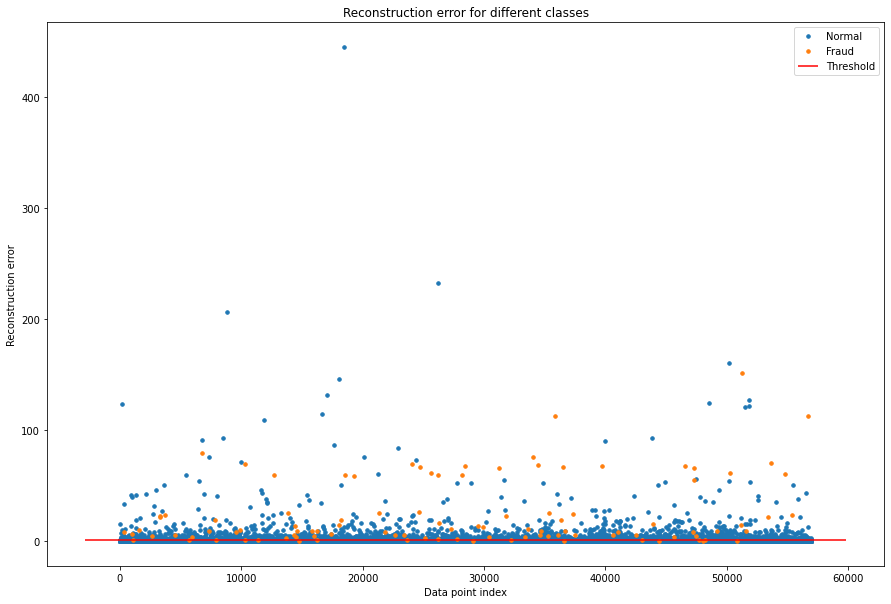

In [ ]:
# scatter plot
threshold = 0.9
groups = error_df.groupby('true_class')
fig, ax = plt.subplots(figsize=(15, 10))

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

### (2) Confusion Matrix

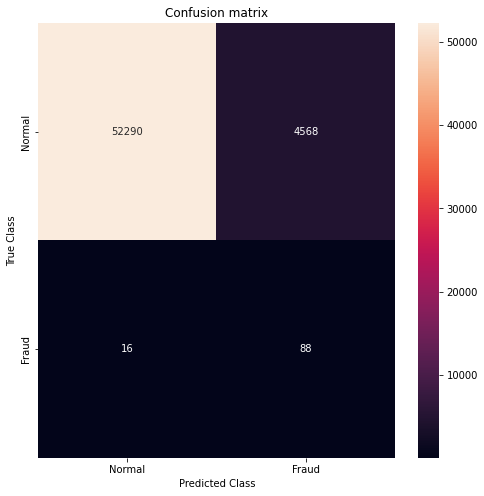

In [ ]:
# confusion matrix
threshold = 0.9
# And see how well we're dividing the two types of transactions:
groups = error_df.groupby('true_class')
# predict fraud
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
# plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

### (3) ROC Curve

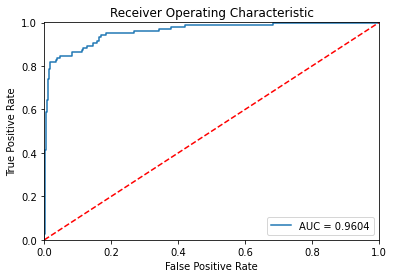

In [ ]:
# ROC
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)
# plot
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();